<a href="https://colab.research.google.com/github/Kaviya-12347/Music_Genre_Classification/blob/main/Deep_Learning_Music_Genre_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries Installation
!pip install python_speech_features #to extract features and to have a different taste
!pip install scipy #to load the dataset in the WAV format

In [ ]:
#Importing required libraries
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator

In [ ]:
#define a function to get distance between feature vectors and find neighbors
#KNN works by calculating distance and finding the K number of neighbours
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


In [ ]:
#With the list of neighbours we have, we need to find out a class that has the maximum neighbours count
#function to identify the nearest neighbors
def nearestclass(neighbors):

    #We declare a dictionary to store the class and its respective count of neighbours
    classVote = {}

    #Creating the frequency map
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    #Sorting the map in descending order based on neighbours count to return the first class
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [ ]:
#Function for Model Evaluation
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [ ]:
#Dataset download
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
directory = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original'
f = open("mydataset.dat", "wb")
i = 0

#Iterate through each category folder
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break

    #Read the audio file and extract the MFCC feature
    #MFCC - Mel Frequency Cepstral Coefficients - helps to extract mid-level and low-level audio features
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)

            #Dump MFCC feature in a binary file using the pickle module
            pickle.dump(feature, f)

        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

Got an exception:  File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported. in folder:  jazz  filename:  jazz.00054.wav


In [ ]:
#Train-test split the dataset
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('mydataset.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('mydataset.dat', 0.68, trainingSet, testSet)

In [ ]:
#Calculate the distance between two instances
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]

    #Find the dot product between the X-X and Y-Y coordinate of both points to know the actual distance
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))

    #Extract the determinant of the resultant array of both points and get the distance
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [ ]:
#Training the Model and making predictions
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))



Accuracy:  0.6878612716763006
Precision:  0.7261897688305695
Recall:  0.6878612716763006
F1-score:  0.6987605319050693


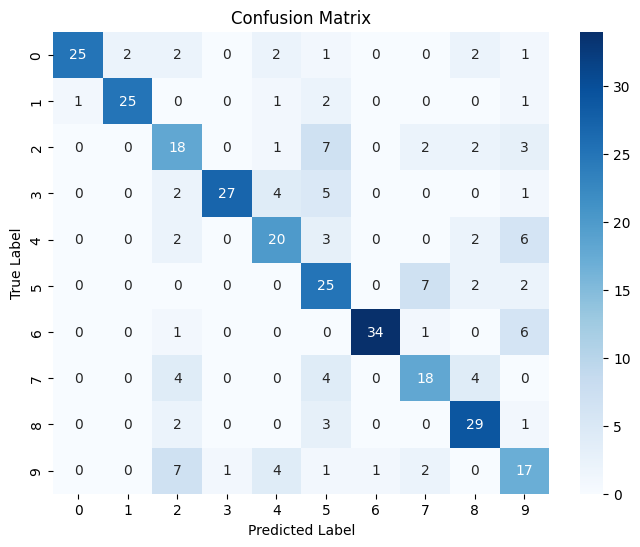

In [ ]:
#Evaluate model performance and visualize metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score( [x[-1] for x in testSet], predictions)
print("Accuracy: ", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score([x[-1] for x in testSet], predictions, average='weighted')
recall = recall_score([x[-1] for x in testSet], predictions, average='weighted')
f1 = f1_score([x[-1] for x in testSet], predictions, average='weighted')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)


# Generate and visualize confusion matrix
cm = confusion_matrix([x[-1] for x in testSet], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#Test the Classifier with the new Audio File
from collections import defaultdict
results = defaultdict(int)

directory = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [ ]:
#Predict a new audio file and print the name of the category
pred = nearestclass(getNeighbors (dataset, feature, 5))

print(results[pred])

rock
